In [1]:
import sys
import os
from pathlib import Path
import importlib

# Add project root to path
PROJECT_ROOT = Path('/mnt/home/mlee1/vdm_BIND')
sys.path.insert(0, str(PROJECT_ROOT))

# Force reload of bind module to pick up any changes
# This is important if workflow_utils.py was modified since kernel start
for mod_name in list(sys.modules.keys()):
    if mod_name.startswith('bind') or mod_name.startswith('vdm'):
        del sys.modules[mod_name]

import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm
import matplotlib.gridspec as gridspec
from tqdm import tqdm
import joblib

# Import from our codebase (fresh import after clearing cache)
from bind.workflow_utils import ConfigLoader, ModelManager, sample, load_normalization_stats
from vdm.astro_dataset import get_astro_data

# Setup publication-quality plotting
plt.rcParams.update({
    'font.size': 14,
    'font.family': 'serif',
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 11,
    'figure.figsize': (12, 8),
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
})

# Output directory for figures
FIGURE_DIR = PROJECT_ROOT / 'analysis' / 'figures' / 'training'
FIGURE_DIR.mkdir(parents=True, exist_ok=True)
print(f"Figures will be saved to: {FIGURE_DIR}")

/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/mnt/sw/nix/store/6qvrglgqdpwhbw9zv2nh07fpd7a4wq31-py-torchvision-0.15.2/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Figures will be saved to: /mnt/home/mlee1/vdm_BIND/analysis/figures/training


## Configuration

Select the model type and config to use.

In [32]:
# ============================================================================
# MODEL CONFIGURATION - MODIFY THIS SECTION
# ============================================================================

# Model type: 'clean' (3-channel joint), 'triple' (3 separate VDMs), 'ddpm' (score_models), or 'interpolant' (flow matching)
MODEL_TYPE = 'interpolant'  # Options: 'clean', 'triple', 'ddpm', 'interpolant'

# Config file path - auto-select based on MODEL_TYPE or set manually
if MODEL_TYPE == 'clean':
    CONFIG_PATH = PROJECT_ROOT / 'configs' / 'clean_vdm_aggressive_stellar.ini'
elif MODEL_TYPE == 'triple':
    CONFIG_PATH = PROJECT_ROOT / 'configs' / 'clean_vdm_triple.ini'
elif MODEL_TYPE == 'ddpm':
    CONFIG_PATH = PROJECT_ROOT / 'configs' / 'ddpm.ini'
elif MODEL_TYPE == 'interpolant':
    CONFIG_PATH = PROJECT_ROOT / 'configs' / 'interpolant.ini'
else:
    raise ValueError(f"Unknown MODEL_TYPE: {MODEL_TYPE}. Use 'clean', 'triple', 'ddpm', or 'interpolant'")

# Number of test samples to visualize
N_SAMPLES = 5

# Number of stochastic realizations per sample
N_REALIZATIONS = 4

# Sampling steps (used for DDPM and interpolant)
SAMPLING_STEPS = 50  # 50 for interpolant, 1000 for DDPM

# Device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Model type: {MODEL_TYPE}")
print(f"Config: {CONFIG_PATH}")
print(f"Device: {DEVICE}")
if MODEL_TYPE in ['ddpm', 'interpolant']:
    print(f"Sampling steps: {SAMPLING_STEPS}")

Model type: interpolant
Config: /mnt/home/mlee1/vdm_BIND/configs/interpolant.ini
Device: cuda
Sampling steps: 50


## Load Model and Test Data

In [33]:
# Load configuration
config = ConfigLoader(str(CONFIG_PATH), verbose=True)

# Resolve relative paths to absolute paths
if hasattr(config, 'quantile_path') and config.quantile_path is not None:
    if not os.path.isabs(config.quantile_path):
        config.quantile_path = str(PROJECT_ROOT / config.quantile_path)
        print(f"Resolved quantile_path to: {config.quantile_path}")

print(f"\nModel: {config.model_name}")
print(f"Checkpoint: {config.best_ckpt}")

[ConfigLoader] Found conditioning_channels in config: 1
[ConfigLoader] WARNING: This will be overridden by checkpoint auto-detection!
[ConfigLoader] Loaded config from: /mnt/home/mlee1/vdm_BIND/configs/interpolant.ini
[ConfigLoader] Parameters:
  seed: 8
  dataset: IllustrisTNG
  data_root: /mnt/home/mlee1/ceph/train_data_rotated2_128_cpu/train/
  field: gas
  boxsize: 6.25
  batch_size: 64
  accumulate_grad_batches: 4
  num_workers: 8
  cropsize: 128
  max_epochs: 250
  learning_rate: 0.0001
  weight_decay: 1e-5
  lr_scheduler: cosine
  embedding_dim: 256
  n_blocks: 5
  norm_groups: 8
  n_attention_heads: 8
  conditioning_channels: 1
  large_scale_channels: 3
  use_fourier_features: True
  fourier_legacy: False
  add_attention: True
  use_param_conditioning: True
  param_norm_path: /mnt/home/mlee1/Sims/IllustrisTNG_extras/L50n512/SB35/SB35_param_minmax.csv
  x0_mode: dm_copy
  use_stochastic_interpolant: False
  sigma: 0.0
  n_sampling_steps: 50
  enable_ema: True
  ema_decay: 0.9999

In [34]:
# Load model and test dataloader
# ModelManager now supports 'clean', 'triple', 'ddpm', and 'interpolant' models automatically
print("\nLoading model and test data...")
print(f"Configured model type: {MODEL_TYPE}")

# Check that checkpoint exists
if config.best_ckpt is None:
    raise ValueError(f"No checkpoint found for model {config.model_name}")

# ModelManager.initialize() auto-detects model type from config.model_name or checkpoint
test_loader, model = ModelManager.initialize(config, verbose=True, skip_data_loading=False)

# Detect actual model type (may differ from configured if checkpoint is different)
detected_type = ModelManager.detect_model_type(config, verbose=True)
print(f"Detected model type: {detected_type}")

# IMPORTANT: Verify the model class is correct
model_class = type(model).__name__
print(f"\n>>> Model class loaded: {model_class}")

if detected_type == 'ddpm':
    if model_class == 'DDPMModelWrapper':
        print("✓ Correct model class - using fixed score_models loading")
    elif model_class == 'LightScoreModel':
        print("⚠️  WARNING: Old LightScoreModel detected!")
        print("   The workflow_utils.py may not have been reloaded.")
        print("   Please RESTART KERNEL and re-run all cells.")
    else:
        print(f"⚠️  Unexpected model class: {model_class}")
elif detected_type == 'interpolant':
    if model_class == 'LightInterpolant':
        print("✓ Correct model class - LightInterpolant")
    else:
        print(f"⚠️  Unexpected model class for interpolant: {model_class}")

# Move model to device
model = model.to(DEVICE)
model.eval()

# Get actual DataLoader from DataModule (for all model types)
actual_loader = test_loader.test_dataloader()
print(f"\n✓ Model loaded successfully")
print(f"Test dataset size: {len(test_loader.dataset)}")

# For DDPM/Interpolant models, update sampling steps if specified
if detected_type == 'ddpm' and hasattr(model, 'n_sampling_steps'):
    model.n_sampling_steps = SAMPLING_STEPS
    model.hparams.n_sampling_steps = SAMPLING_STEPS
    print(f"✓ Set DDPM sampling steps to {SAMPLING_STEPS}")
elif detected_type == 'interpolant' and hasattr(model, 'n_sampling_steps'):
    model.n_sampling_steps = SAMPLING_STEPS
    if hasattr(model, 'hparams'):
        model.hparams.n_sampling_steps = SAMPLING_STEPS
    print(f"✓ Set Interpolant sampling steps to {SAMPLING_STEPS}")

Seed set to 8



Loading model and test data...
Configured model type: interpolant
[ModelManager] Detected 'interpolant' model from model_name: interpolant_3ch
[ModelManager] Initializing INTERPOLANT/Flow Matching model...
[ModelManager] Using seed: 8
[ModelManager] Checkpoint path: /mnt/home/mlee1/ceph/tb_logs//interpolant_3ch/version_0/version_4/checkpoints/epoch-epoch=003-step=1280.ckpt
[ModelManager] Loaded hyperparameters from checkpoint:
  learning_rate: 0.0001
  weight_decay: 1e-05
  lr_scheduler: cosine
  n_sampling_steps: 50
  use_stochastic_interpolant: False
  sigma: 0.0
  use_param_conditioning: True
  x0_mode: dm_copy
[ModelManager] Interpolant Model Configuration:
  x0 mode: dm_copy
  Stochastic: False (sigma=0.0)
  Sampling steps: 50
  Conditioning channels: 4
  Param conditioning: True
[ModelManager] Loaded 35 param bounds from /mnt/home/mlee1/Sims/IllustrisTNG_extras/L50n512/SB35/SB35_param_minmax.csv
✓ Scale-appropriate Fourier features enabled:
  - Halo (m_dm): High frequencies [1, 

In [35]:
# Load normalization statistics
norm_stats = load_normalization_stats()

# Check if using quantile normalization for stars
use_quantile = hasattr(config, 'quantile_path') and config.quantile_path is not None
if use_quantile:
    quantile_path = config.quantile_path
    # Resolve relative path if needed
    if not os.path.isabs(quantile_path):
        quantile_path = str(PROJECT_ROOT / quantile_path)
    quantile_transformer = joblib.load(quantile_path)
    print(f"Using quantile normalization for stars: {quantile_path}")
else:
    quantile_transformer = None
    print(f"Using Z-score normalization for all channels")

✓ Loaded DM normalization: mean=9.915499, std=0.467967
✓ Loaded Gas normalization: mean=9.177344, std=0.410510
✓ Loaded Stellar normalization: mean=6.995926, std=1.100350
Using Z-score normalization for all channels


## Unnormalization Functions

In [36]:
def unnormalize_field(field, channel_idx, norm_stats, quantile_transformer=None):
    """
    Unnormalize a field from normalized space back to physical units.
    
    Args:
        field: Normalized field (can be 2D or higher)
        channel_idx: 0=DM, 1=Gas, 2=Stars
        norm_stats: Dictionary with normalization statistics
        quantile_transformer: Optional quantile transformer for stars
    
    Returns:
        Field in physical units (mass density)
    """
    if channel_idx == 0:  # DM
        mean, std = norm_stats['dm_mag_mean'], norm_stats['dm_mag_std']
    elif channel_idx == 1:  # Gas
        mean, std = norm_stats['gas_mag_mean'], norm_stats['gas_mag_std']
    elif channel_idx == 2:  # Stars
        if quantile_transformer is not None:
            # Quantile inverse transform
            original_shape = field.shape
            field_flat = field.flatten().reshape(-1, 1)
            log_field = quantile_transformer.inverse_transform(field_flat)
            log_field = log_field.reshape(original_shape)
            return 10**log_field - 1
        else:
            mean, std = norm_stats['star_mag_mean'], norm_stats['star_mag_std']
    else:
        raise ValueError(f"Unknown channel index: {channel_idx}")
    
    # Z-score inverse: log_field = field * std + mean
    log_field = field * std + mean
    return 10**log_field - 1


def unnormalize_condition(field, norm_stats):
    """
    Unnormalize DM condition field.
    """
    # Use DM condition stats (different from target DM stats)
    mean = norm_stats.get('dm_condition_mean', norm_stats['dm_mag_mean'])
    std = norm_stats.get('dm_condition_std', norm_stats['dm_mag_std'])
    log_field = field * std + mean
    return 10**log_field - 1

## Load Test Samples and Generate Predictions

In [37]:
# Get a batch of test samples
# test_loader is a DataModule, need to get the actual dataloader
if hasattr(test_loader, 'test_dataloader'):
    actual_loader = test_loader.test_dataloader()
elif hasattr(test_loader, 'val_dataloader'):
    actual_loader = test_loader.val_dataloader()
else:
    actual_loader = test_loader

test_iter = iter(actual_loader)
batch = next(test_iter)

# Unpack batch (structure depends on dataset)
if len(batch) == 4:
    # (dm_condition, large_scale, target, params)
    conditions_dm, large_scale, targets, params = batch
    # Concatenate DM condition with large-scale context
    conditions = torch.cat([conditions_dm, large_scale], dim=1)
elif len(batch) == 3:
    conditions, targets, params = batch
elif len(batch) == 2:
    conditions, targets = batch
    params = None
else:
    raise ValueError(f"Unexpected batch structure: {len(batch)} elements")

print(f"Conditions shape: {conditions.shape}")
print(f"Targets shape: {targets.shape}")
if params is not None:
    print(f"Params shape: {params.shape}")

Conditions shape: torch.Size([1, 4, 128, 128])
Targets shape: torch.Size([1, 3, 128, 128])
Params shape: torch.Size([1, 35])


In [38]:
# Select samples to visualize
sample_indices = list(range(min(N_SAMPLES, conditions.shape[0])))

# Extract selected samples
selected_conditions = conditions[sample_indices]
selected_targets = targets[sample_indices]
selected_params = params[sample_indices] if params is not None else None

print(f"Selected {len(sample_indices)} samples for generation")

Selected 1 samples for generation


In [39]:
# Generate predictions
print(f"Generating {N_REALIZATIONS} realizations per sample...")
print(f"Model type: {detected_type}")
print(f"Model class: {type(model).__name__}")

# Verify we have the correct model type
if detected_type == 'ddpm':
    if type(model).__name__ != 'DDPMModelWrapper':
        print(f"\n⚠️  WARNING: Expected DDPMModelWrapper but got {type(model).__name__}")
        print("   Please restart kernel and re-run all cells to pick up the fixed ModelManager")
    else:
        print(f"✓ Using correct DDPMModelWrapper")
elif detected_type == 'interpolant':
    if type(model).__name__ != 'LightInterpolant':
        print(f"\n⚠️  WARNING: Expected LightInterpolant but got {type(model).__name__}")
        print("   Please restart kernel and re-run all cells")
    else:
        print(f"✓ Using correct LightInterpolant")

# Move model to device
model = model.to(DEVICE)

# For DDPM/Interpolant models, show and set sampling configuration
if detected_type in ['ddpm', 'interpolant']:
    # Set the sampling steps from our config
    model.n_sampling_steps = SAMPLING_STEPS
    if hasattr(model, 'hparams'):
        model.hparams.n_sampling_steps = SAMPLING_STEPS
    
    print(f"\nSampling configuration:")
    print(f"  SAMPLING_STEPS: {SAMPLING_STEPS}")
    print(f"  model.n_sampling_steps: {model.n_sampling_steps}")
    if hasattr(model, 'hparams'):
        print(f"  model.hparams.n_sampling_steps: {model.hparams.n_sampling_steps}")

# Generate samples
generated = sample(
    model,
    selected_conditions,
    batch_size=N_REALIZATIONS,
    conditional_params=selected_params
)

print(f"\nGenerated shape: {generated.shape}")
print(f"Generated stats: mean={generated.mean():.4f}, std={generated.std():.4f}")
# Shape: (N_SAMPLES, N_REALIZATIONS, 3, H, W)

Generating 4 realizations per sample...
Model type: interpolant
Model class: LightInterpolant
✓ Using correct LightInterpolant

Sampling configuration:
  SAMPLING_STEPS: 50
  model.n_sampling_steps: 50
  model.hparams.n_sampling_steps: 50


Generating Samples:   0%|          | 0/1 [00:00<?, ?it/s]/mnt/home/mlee1/vdm_BIND/bind/workflow_utils.py:1445: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  param_row = torch.tensor(conditional_params[i], dtype=torch.float32, device='cuda')
/mnt/home/mlee1/vdm_BIND/bind/workflow_utils.py:1445: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  param_row = torch.tensor(conditional_params[i], dtype=torch.float32, device='cuda')
Generating Samples: 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


Generated shape: torch.Size([1, 4, 3, 128, 128])
Generated stats: mean=-1.2434, std=3.0215


## Visual Comparison: Input → Generated → Ground Truth

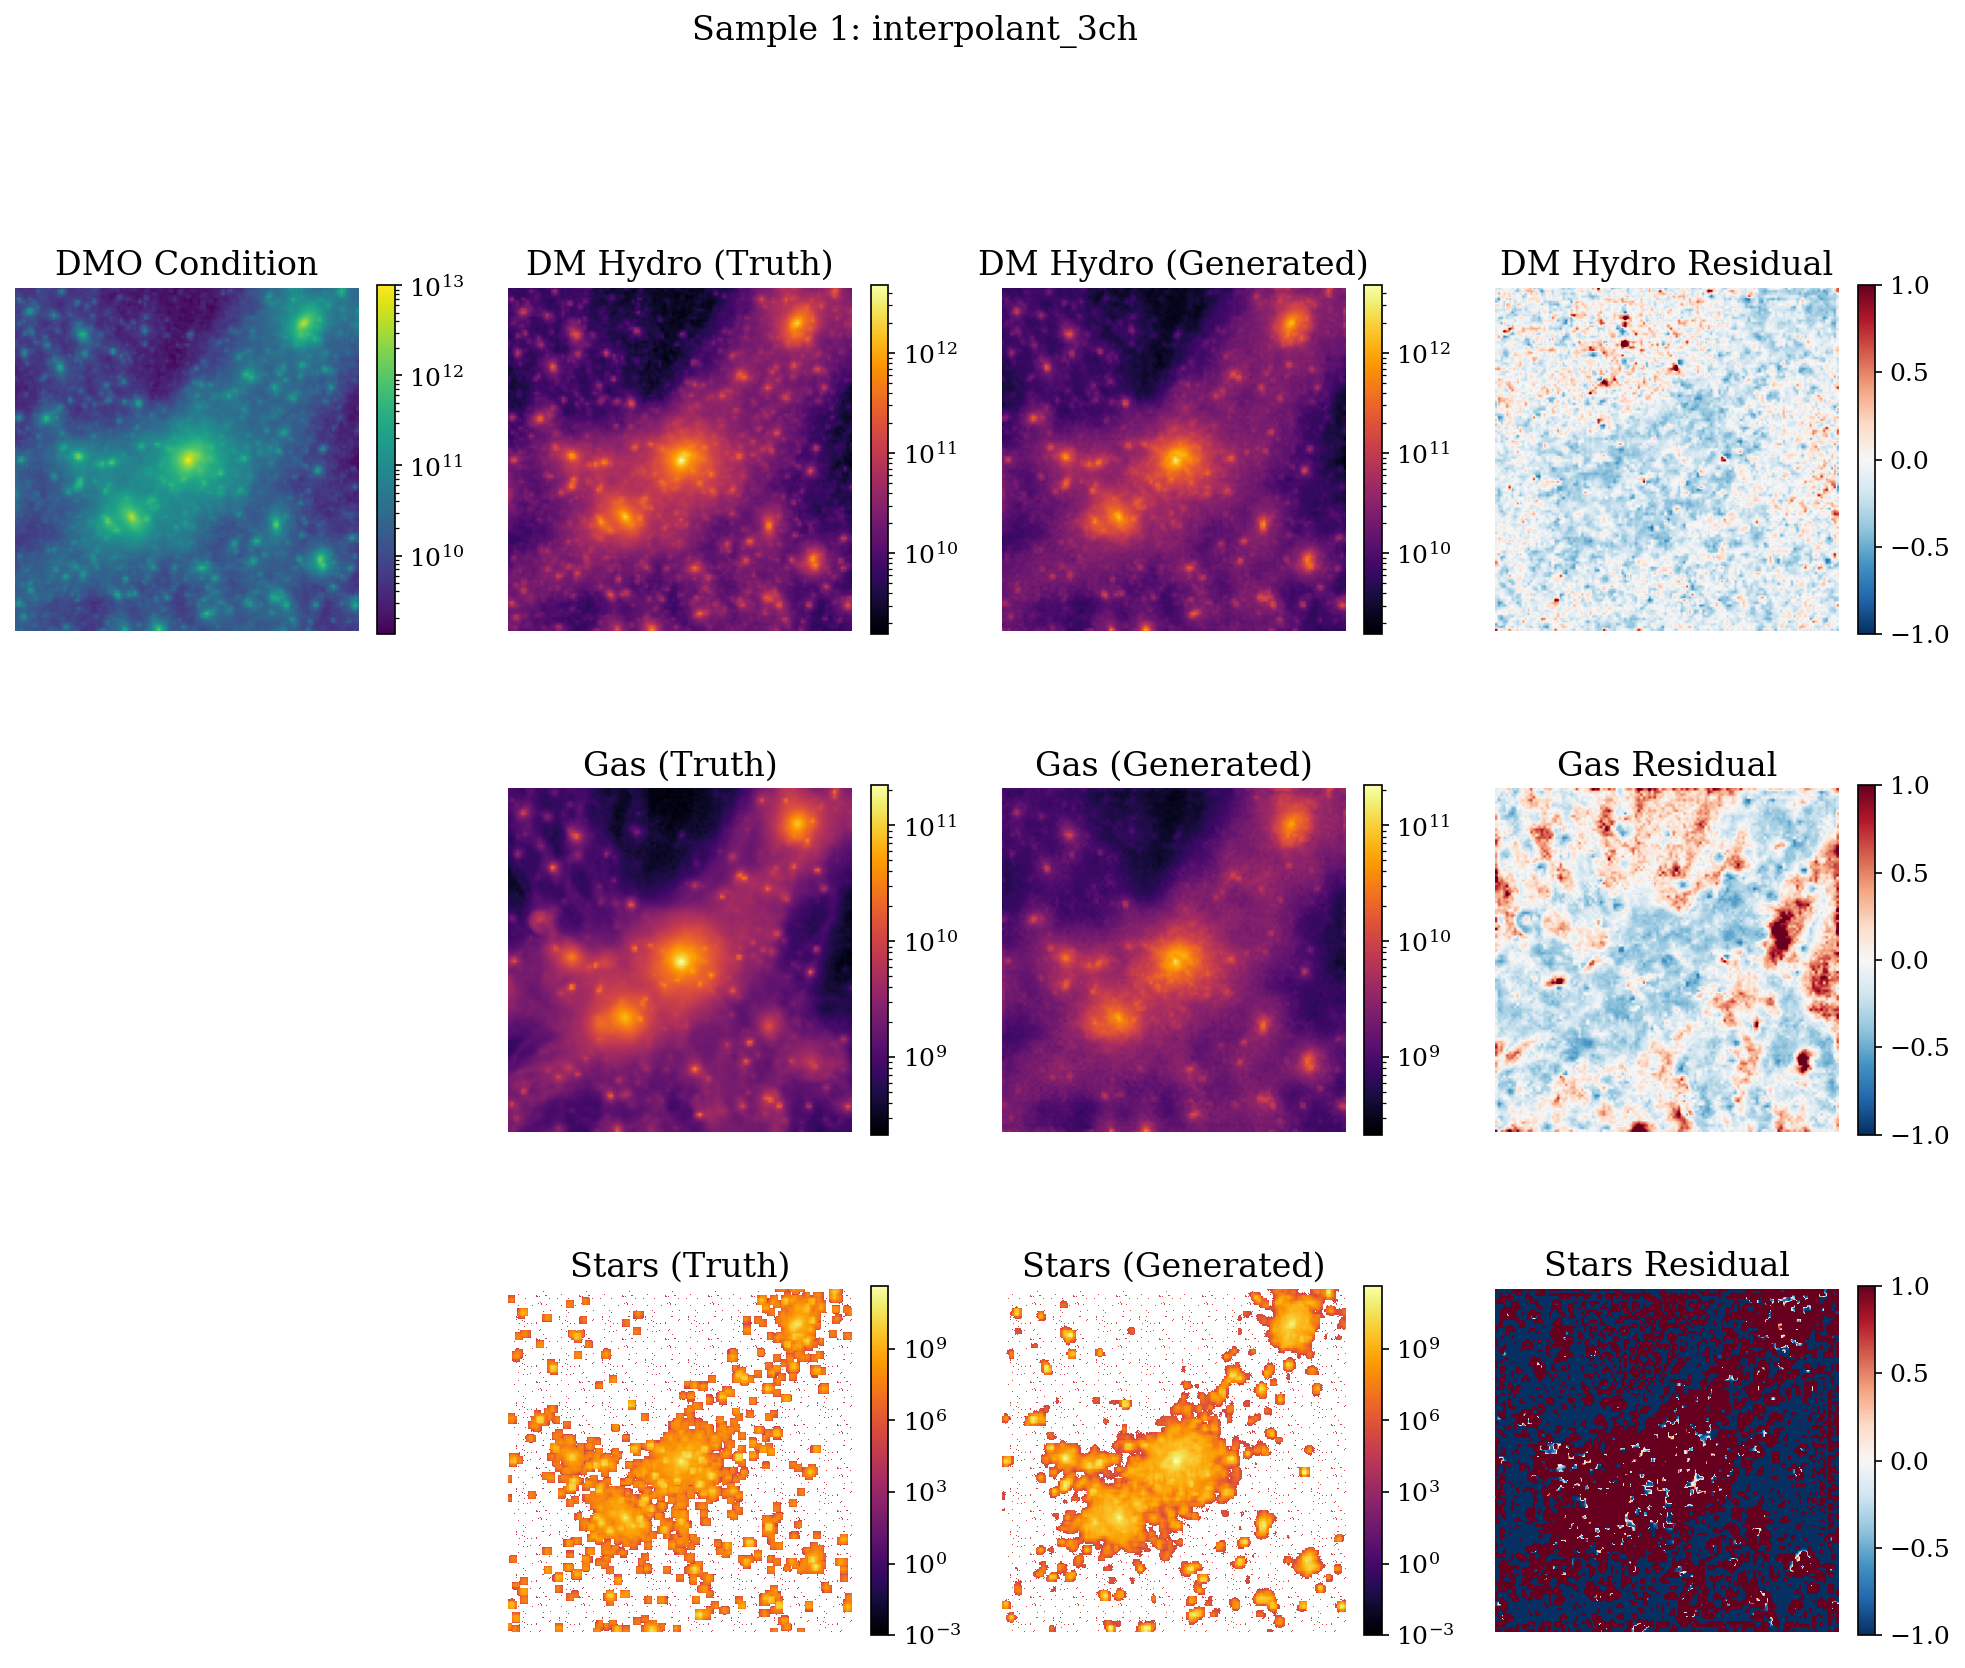


✓ Plotted 1 samples


In [40]:
channel_names = ['DM Hydro', 'Gas', 'Stars']

# Only iterate over actual samples we have
n_samples_to_plot = min(3, len(selected_conditions))

for sample_idx in range(n_samples_to_plot):
    fig = plt.figure(figsize=(16, 12))
    gs = gridspec.GridSpec(3, 4, figure=fig, hspace=0.3, wspace=0.3)
    
    # Get data for this sample
    condition = selected_conditions[sample_idx].numpy()
    target = selected_targets[sample_idx].numpy()
    gen_mean = generated[sample_idx].mean(dim=0).numpy()  # Mean over realizations
    gen_std = generated[sample_idx].std(dim=0).numpy()    # Std over realizations
    
    for ch_idx, ch_name in enumerate(channel_names):
        # Unnormalize
        target_unnorm = unnormalize_field(target[ch_idx], ch_idx, norm_stats, quantile_transformer)
        gen_unnorm = unnormalize_field(gen_mean[ch_idx], ch_idx, norm_stats, quantile_transformer)
        
        # Determine color scale
        vmin = max(1e-3, min(target_unnorm.min(), gen_unnorm.min()))
        vmax = max(target_unnorm.max(), gen_unnorm.max())
        norm = LogNorm(vmin=vmin, vmax=vmax)
        
        # Column 1: Condition (only show once, or DM channel)
        if ch_idx == 0:
            ax = fig.add_subplot(gs[ch_idx, 0])
            cond_unnorm = unnormalize_condition(condition[0], norm_stats)
            im = ax.imshow(cond_unnorm, cmap='viridis', norm=LogNorm())
            ax.set_title('DMO Condition')
            ax.axis('off')
            plt.colorbar(im, ax=ax, fraction=0.046)
        else:
            ax = fig.add_subplot(gs[ch_idx, 0])
            ax.axis('off')
        
        # Column 2: Ground Truth
        ax = fig.add_subplot(gs[ch_idx, 1])
        im = ax.imshow(target_unnorm, cmap='inferno', norm=norm)
        ax.set_title(f'{ch_name} (Truth)')
        ax.axis('off')
        plt.colorbar(im, ax=ax, fraction=0.046)
        
        # Column 3: Generated (mean)
        ax = fig.add_subplot(gs[ch_idx, 2])
        im = ax.imshow(gen_unnorm, cmap='inferno', norm=norm)
        ax.set_title(f'{ch_name} (Generated)')
        ax.axis('off')
        plt.colorbar(im, ax=ax, fraction=0.046)
        
        # Column 4: Residual
        ax = fig.add_subplot(gs[ch_idx, 3])
        residual = (gen_unnorm - target_unnorm) / (target_unnorm + 1e-10)
        im = ax.imshow(residual, cmap='RdBu_r', vmin=-1, vmax=1)
        ax.set_title(f'{ch_name} Residual')
        ax.axis('off')
        plt.colorbar(im, ax=ax, fraction=0.046)
    
    plt.suptitle(f'Sample {sample_idx + 1}: {config.model_name}', fontsize=16, y=1.02)
    
    # Save figure
    fig.savefig(str(FIGURE_DIR / f'{config.model_name}_sample_{sample_idx}_comparison.png'))
    plt.show()

print(f"\n✓ Plotted {n_samples_to_plot} samples")

## Radial Density Profiles

Compute azimuthally-averaged density profiles around halo centers.

In [41]:
def compute_radial_profile(image, center=None, n_bins=50, r_max=None):
    """
    Compute azimuthally-averaged radial profile.
    
    Args:
        image: 2D array
        center: (y, x) center coordinates. If None, use image center.
        n_bins: Number of radial bins
        r_max: Maximum radius. If None, use half the image size.
    
    Returns:
        r_bins: Radial bin centers
        profile: Mean value in each radial bin
        profile_std: Standard deviation in each radial bin
    """
    ny, nx = image.shape
    
    if center is None:
        center = (ny // 2, nx // 2)
    
    if r_max is None:
        r_max = min(ny, nx) // 2
    
    # Create coordinate grids
    y, x = np.ogrid[:ny, :nx]
    r = np.sqrt((x - center[1])**2 + (y - center[0])**2)
    
    # Create radial bins
    r_bins = np.linspace(0, r_max, n_bins + 1)
    r_centers = 0.5 * (r_bins[:-1] + r_bins[1:])
    
    # Compute profile
    profile = np.zeros(n_bins)
    profile_std = np.zeros(n_bins)
    
    for i in range(n_bins):
        mask = (r >= r_bins[i]) & (r < r_bins[i+1])
        if mask.sum() > 0:
            profile[i] = np.mean(image[mask])
            profile_std[i] = np.std(image[mask])
    
    return r_centers, profile, profile_std

In [42]:
N_SAMPLES

5

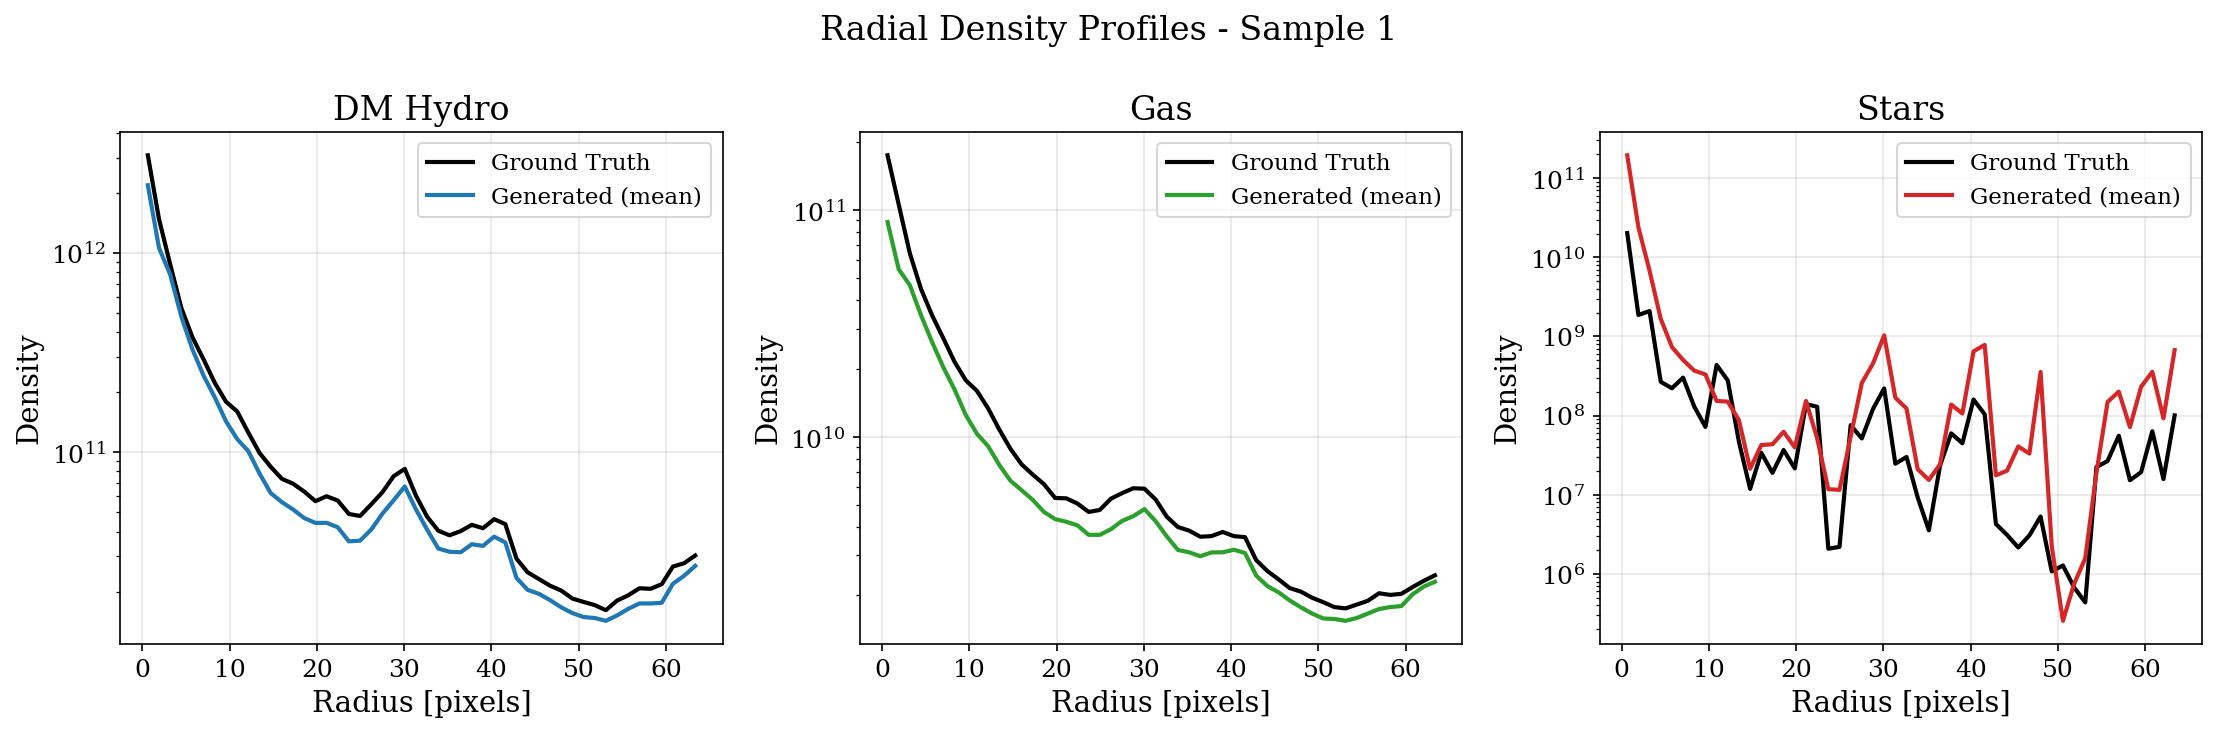

In [43]:
# Compute and plot radial profiles for each sample
channel_colors = ['#1f77b4', '#2ca02c', '#d62728']  # Blue, Green, Red

for sample_idx in range(min(1, N_SAMPLES)):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    target = selected_targets[sample_idx].numpy()
    gen_samples = generated[sample_idx].numpy()  # (N_REALIZATIONS, 3, H, W)
    
    for ch_idx, (ax, ch_name) in enumerate(zip(axes, channel_names)):
        # Unnormalize
        target_unnorm = unnormalize_field(target[ch_idx], ch_idx, norm_stats, quantile_transformer)
        
        # Ground truth profile
        r, profile_true, _ = compute_radial_profile(target_unnorm)
        ax.plot(r, profile_true, 'k-', linewidth=2, label='Ground Truth')
        
        # Generated profiles (multiple realizations)
        gen_profiles = []
        for real_idx in range(N_REALIZATIONS):
            gen_unnorm = unnormalize_field(gen_samples[real_idx, ch_idx], ch_idx, norm_stats, quantile_transformer)
            r, profile_gen, _ = compute_radial_profile(gen_unnorm)
            gen_profiles.append(profile_gen)
            ax.plot(r, profile_gen, '-', color=channel_colors[ch_idx], 
                   alpha=0.3, linewidth=1)
        
        # Mean generated profile
        gen_profiles = np.array(gen_profiles)
        gen_mean = gen_profiles.mean(axis=0)
        gen_std = gen_profiles.std(axis=0)
        
        ax.plot(r, gen_mean, '-', color=channel_colors[ch_idx], 
               linewidth=2, label='Generated (mean)')
        ax.fill_between(r, gen_mean - gen_std, gen_mean + gen_std, 
                       color=channel_colors[ch_idx], alpha=0.2)
        
        ax.set_xlabel('Radius [pixels]')
        ax.set_ylabel('Density')
        ax.set_title(ch_name)
        ax.set_yscale('log')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'Radial Density Profiles - Sample {sample_idx + 1}', fontsize=16)
    plt.tight_layout()
    
    fig.savefig(str(FIGURE_DIR / f'{config.model_name}_sample_{sample_idx}_profiles.png'))
    plt.show()

## Profile Residuals Analysis

In [44]:
# Aggregate profiles across all samples
all_residuals = {ch: [] for ch in channel_names}

for sample_idx in range(min(1, N_SAMPLES)):
    target = selected_targets[sample_idx].numpy()
    gen_mean = generated[sample_idx].mean(dim=0).numpy()
    
    for ch_idx, ch_name in enumerate(channel_names):
        target_unnorm = unnormalize_field(target[ch_idx], ch_idx, norm_stats, quantile_transformer)
        gen_unnorm = unnormalize_field(gen_mean[ch_idx], ch_idx, norm_stats, quantile_transformer)
        
        r, profile_true, _ = compute_radial_profile(target_unnorm)
        _, profile_gen, _ = compute_radial_profile(gen_unnorm)
        
        residual = (profile_gen - profile_true) / (profile_true + 1e-10)
        all_residuals[ch_name].append(residual)

# Convert to arrays
for ch_name in channel_names:
    all_residuals[ch_name] = np.array(all_residuals[ch_name])

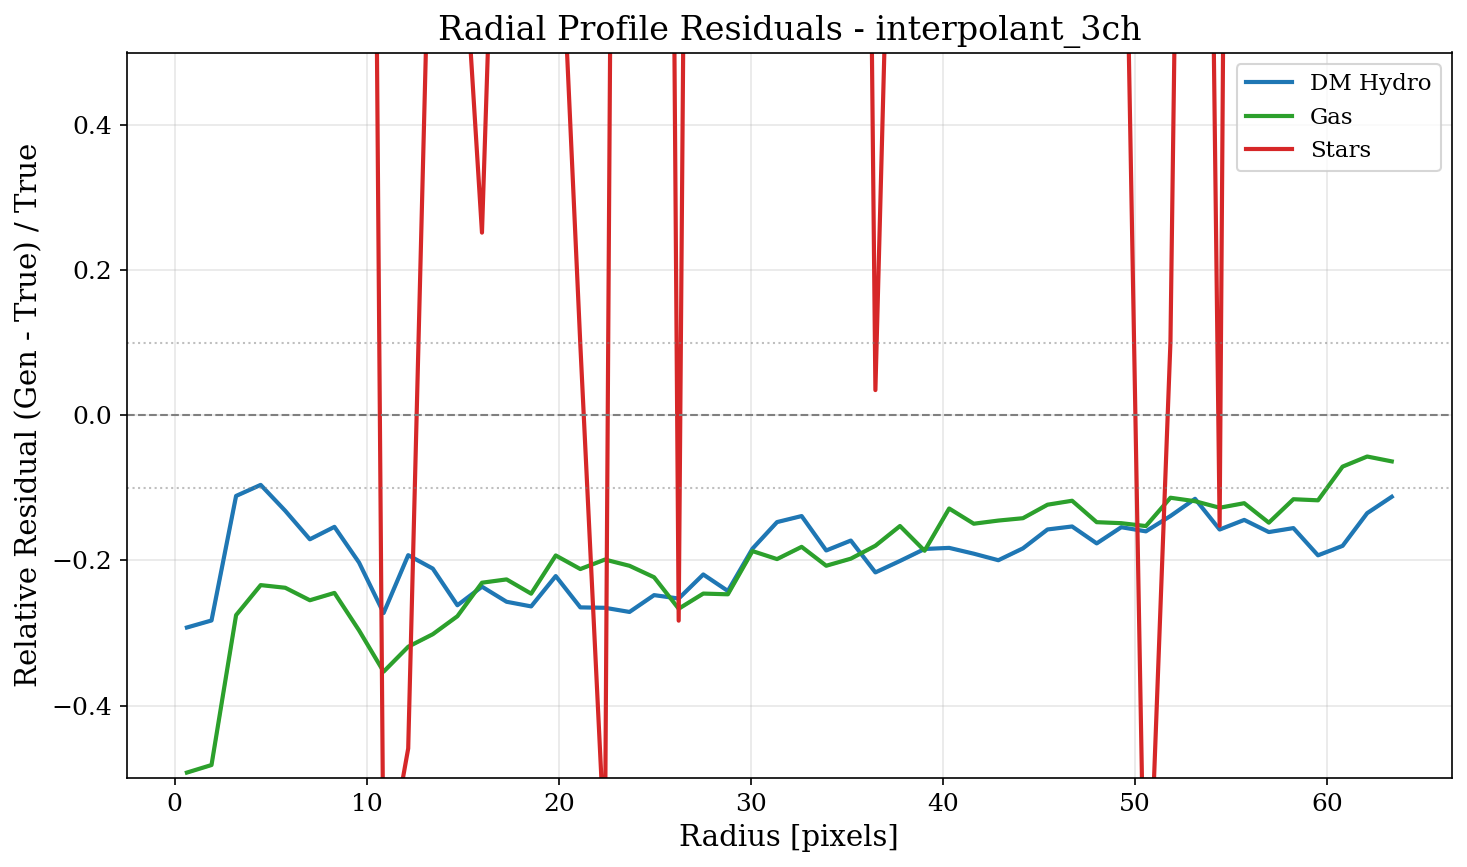

In [45]:
# Plot aggregated residuals
fig, ax = plt.subplots(figsize=(10, 6))

for ch_idx, (ch_name, color) in enumerate(zip(channel_names, channel_colors)):
    residuals = all_residuals[ch_name]
    mean_res = residuals.mean(axis=0)
    std_res = residuals.std(axis=0)
    
    ax.plot(r, mean_res, '-', color=color, linewidth=2, label=ch_name)
    ax.fill_between(r, mean_res - std_res, mean_res + std_res, 
                   color=color, alpha=0.2)

ax.axhline(y=0, color='gray', linestyle='--', linewidth=1)
ax.axhline(y=0.1, color='gray', linestyle=':', linewidth=1, alpha=0.5)
ax.axhline(y=-0.1, color='gray', linestyle=':', linewidth=1, alpha=0.5)

ax.set_xlabel('Radius [pixels]')
ax.set_ylabel('Relative Residual (Gen - True) / True')
ax.set_title(f'Radial Profile Residuals - {config.model_name}')
ax.set_ylim(-0.5, 0.5)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
fig.savefig(str(FIGURE_DIR / f'{config.model_name}_profile_residuals.png'))
plt.show()

## Summary Statistics

In [31]:
print(f"\n{'='*60}")
print(f"Validation Summary: {config.model_name}")
print(f"{'='*60}\n")

print(f"Model type: {detected_type}")
print(f"Test samples evaluated: {N_SAMPLES}")
print(f"Realizations per sample: {N_REALIZATIONS}")
if detected_type in ['ddpm', 'interpolant']:
    print(f"Sampling steps: {SAMPLING_STEPS}")
print()

print("Mean Absolute Relative Error (by channel):")
for ch_name in channel_names:
    residuals = all_residuals[ch_name]
    mare = np.abs(residuals).mean()
    print(f"  {ch_name}: {mare:.4f} ({mare*100:.2f}%)")

print("\nBias (by channel):")
for ch_name in channel_names:
    residuals = all_residuals[ch_name]
    bias = residuals.mean()
    print(f"  {ch_name}: {bias:+.4f} ({bias*100:+.2f}%)")


Validation Summary: interpolant_3ch

Model type: interpolant
Test samples evaluated: 5
Realizations per sample: 4
Sampling steps: 50

Mean Absolute Relative Error (by channel):
  DM Hydro: 0.0901 (9.01%)
  Gas: 0.1407 (14.07%)
  Stars: 0.9205 (92.05%)

Bias (by channel):
  DM Hydro: -0.0852 (-8.52%)
  Gas: +0.0993 (+9.93%)
  Stars: +0.0782 (+7.82%)


## Compare Multiple Models (Optional)

In [ ]:
# ============================================================================
# MODEL COMPARISON - Set to True to enable
# ============================================================================

COMPARE_MODELS = False

# Sampling steps for different model types
SAMPLING_STEPS_CONFIG = {
    'clean': 250,      # VDM uses ~250 steps
    'triple': 250,     # VDM triple uses ~250 steps  
    'ddpm': 250,       # DDPM can use 250-1000 steps
    'interpolant': 50, # Interpolant only needs ~50 steps
}

if COMPARE_MODELS:
    # List of configs to compare: (config_file, label, model_type)
    # All 4 model types are now supported!
    CONFIGS_TO_COMPARE = [
        ('clean_vdm_aggressive_stellar.ini', 'VDM Clean', 'clean'),
        ('clean_vdm_triple.ini', 'VDM Triple', 'triple'),
        ('ddpm.ini', 'DDPM NCSNpp', 'ddpm'),
        ('interpolant.ini', 'Interpolant', 'interpolant'),
    ]
    
    comparison_results = {}
    
    for config_file, label, mtype in CONFIGS_TO_COMPARE:
        config_path = PROJECT_ROOT / 'configs' / config_file
        if not config_path.exists():
            print(f"Config not found: {config_path}")
            continue
            
        print(f"\n{'='*60}")
        print(f"Loading {label} ({mtype})...")
        print(f"{'='*60}")
        
        cfg = ConfigLoader(str(config_path), verbose=False)
        
        # Skip if no checkpoint exists
        if cfg.best_ckpt is None:
            print(f"  ⚠️  No checkpoint found, skipping...")
            continue
        
        print(f"  Checkpoint: {cfg.best_ckpt}")
        
        # Resolve quantile path
        if hasattr(cfg, 'quantile_path') and cfg.quantile_path is not None:
            if not os.path.isabs(cfg.quantile_path):
                cfg.quantile_path = str(PROJECT_ROOT / cfg.quantile_path)
        
        # Load model - ModelManager auto-detects type
        try:
            _, mdl = ModelManager.initialize(cfg, verbose=False, skip_data_loading=True)
            mdl = mdl.to(DEVICE)
            mdl.eval()
        except Exception as e:
            print(f"  ⚠️  Failed to load model: {e}")
            continue
        
        # Set sampling steps based on model type
        sampling_steps = SAMPLING_STEPS_CONFIG.get(mtype, 250)
        if hasattr(mdl, 'n_sampling_steps'):
            mdl.n_sampling_steps = sampling_steps
            if hasattr(mdl, 'hparams'):
                mdl.hparams.n_sampling_steps = sampling_steps
            print(f"  Using {sampling_steps} sampling steps")
        
        # Generate predictions
        print(f"  Generating {N_REALIZATIONS} realizations...")
        import time
        start_time = time.time()
        
        with torch.no_grad():
            gen = sample(mdl, selected_conditions, batch_size=N_REALIZATIONS,
                        conditional_params=selected_params)
        
        gen_time = time.time() - start_time
        print(f"  Generation time: {gen_time:.1f}s ({gen_time/len(selected_conditions):.1f}s per sample)")
        
        # Compute metrics
        residuals = {ch: [] for ch in channel_names}
        pixel_mse = {ch: [] for ch in channel_names}
        
        for sample_idx in range(min(N_SAMPLES, len(selected_targets))):
            target = selected_targets[sample_idx].numpy()
            gen_mean = gen[sample_idx].mean(dim=0).numpy()
            
            for ch_idx, ch_name in enumerate(channel_names):
                target_unnorm = unnormalize_field(target[ch_idx], ch_idx, norm_stats, quantile_transformer)
                gen_unnorm = unnormalize_field(gen_mean[ch_idx], ch_idx, norm_stats, quantile_transformer)
                
                # Radial profile residual
                r, profile_true, _ = compute_radial_profile(target_unnorm)
                _, profile_gen, _ = compute_radial_profile(gen_unnorm)
                residual = (profile_gen - profile_true) / (profile_true + 1e-10)
                residuals[ch_name].append(residual)
                
                # Pixel-wise MSE (in log space)
                log_target = np.log10(target_unnorm + 1)
                log_gen = np.log10(gen_unnorm + 1)
                mse = np.mean((log_target - log_gen)**2)
                pixel_mse[ch_name].append(mse)
        
        comparison_results[label] = {
            'residuals': {ch: np.array(v) for ch, v in residuals.items()},
            'pixel_mse': {ch: np.mean(v) for ch, v in pixel_mse.items()},
            'gen_time': gen_time,
            'model_type': mtype,
            'sampling_steps': sampling_steps,
        }
        print(f"  ✓ Complete")
        
        # Clean up GPU memory
        del mdl
        torch.cuda.empty_cache()
    
    # ==================== RESULTS SUMMARY ====================
    if comparison_results:
        print(f"\n{'='*80}")
        print("MODEL COMPARISON SUMMARY")
        print(f"{'='*80}")
        
        # Print table header
        print(f"\n{'Model':<20} {'Type':<12} {'Steps':<8} {'Time(s)':<10} {'DM MSE':<10} {'Gas MSE':<10} {'Star MSE':<10}")
        print("-" * 90)
        
        for label, results in comparison_results.items():
            mtype = results['model_type']
            steps = results['sampling_steps']
            gen_time = results['gen_time']
            dm_mse = results['pixel_mse']['DM Hydro']
            gas_mse = results['pixel_mse']['Gas']
            star_mse = results['pixel_mse']['Stars']
            print(f"{label:<20} {mtype:<12} {steps:<8} {gen_time:<10.1f} {dm_mse:<10.4f} {gas_mse:<10.4f} {star_mse:<10.4f}")
        
        # ==================== PROFILE RESIDUALS PLOT ====================
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Color scheme for different model types
        color_map = {
            'VDM Clean': '#1f77b4',
            'VDM Triple': '#2ca02c', 
            'DDPM NCSNpp': '#d62728',
            'Interpolant': '#9467bd',
        }
        
        for ch_idx, (ax, ch_name) in enumerate(zip(axes, channel_names)):
            for label, results in comparison_results.items():
                residuals = results['residuals'][ch_name]
                mean_res = residuals.mean(axis=0)
                std_res = residuals.std(axis=0)
                color = color_map.get(label, 'gray')
                
                ax.plot(r, mean_res, '-', linewidth=2, label=label, color=color)
                ax.fill_between(r, mean_res - std_res, mean_res + std_res, 
                               alpha=0.15, color=color)
            
            ax.axhline(y=0, color='gray', linestyle='--', linewidth=1)
            ax.axhline(y=0.1, color='gray', linestyle=':', linewidth=0.5, alpha=0.5)
            ax.axhline(y=-0.1, color='gray', linestyle=':', linewidth=0.5, alpha=0.5)
            ax.set_xlabel('Radius [pixels]')
            ax.set_ylabel('Relative Residual')
            ax.set_title(ch_name)
            ax.set_ylim(-0.5, 0.5)
            ax.legend(fontsize=9)
            ax.grid(True, alpha=0.3)
        
        plt.suptitle('Model Comparison: Radial Profile Residuals', fontsize=16)
        plt.tight_layout()
        fig.savefig(str(FIGURE_DIR / 'model_comparison_profiles.png'), dpi=150)
        plt.show()
        
        # ==================== MSE BAR CHART ====================
        fig, ax = plt.subplots(figsize=(10, 6))
        
        models = list(comparison_results.keys())
        x = np.arange(len(models))
        width = 0.25
        
        dm_mse = [comparison_results[m]['pixel_mse']['DM Hydro'] for m in models]
        gas_mse = [comparison_results[m]['pixel_mse']['Gas'] for m in models]
        star_mse = [comparison_results[m]['pixel_mse']['Stars'] for m in models]
        
        ax.bar(x - width, dm_mse, width, label='DM Hydro', color='#1f77b4')
        ax.bar(x, gas_mse, width, label='Gas', color='#2ca02c')
        ax.bar(x + width, star_mse, width, label='Stars', color='#d62728')
        
        ax.set_xlabel('Model')
        ax.set_ylabel('Log-space MSE')
        ax.set_title('Pixel-wise MSE by Model and Channel')
        ax.set_xticks(x)
        ax.set_xticklabels(models, rotation=15, ha='right')
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        fig.savefig(str(FIGURE_DIR / 'model_comparison_mse.png'), dpi=150)
        plt.show()
        
        # ==================== GENERATION TIME COMPARISON ====================
        fig, ax = plt.subplots(figsize=(8, 5))
        
        times = [comparison_results[m]['gen_time'] for m in models]
        colors = [color_map.get(m, 'gray') for m in models]
        
        bars = ax.bar(models, times, color=colors)
        ax.set_xlabel('Model')
        ax.set_ylabel('Generation Time (s)')
        ax.set_title(f'Generation Time ({N_SAMPLES} samples, {N_REALIZATIONS} realizations)')
        ax.tick_params(axis='x', rotation=15)
        
        # Add value labels on bars
        for bar, t in zip(bars, times):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                   f'{t:.1f}s', ha='center', va='bottom', fontsize=10)
        
        plt.tight_layout()
        fig.savefig(str(FIGURE_DIR / 'model_comparison_time.png'), dpi=150)
        plt.show()
        
    else:
        print("\n⚠️  No models with checkpoints found for comparison.")